# Xgboost

In [55]:
# !pip install xgboost

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.stattools import acf
import missingno as msno

In [57]:
def load_data():
    df = pd.read_csv('../data/ywan1077/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    # df = pd.read_csv('/users/ywan1077/data/yye45/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    return df

In [58]:
df = load_data()
df.head()

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
0,0,0,0,0,0,5000+,1,517.81,517.81,2024-08-01,...,1882.21,4.0,470.5525,535.92,400.77,NaN,NaN,0,0,8
1,2,0,0,2,1,0-1000,1,150.00,150.00,2024-04-25,...,150.00,1.0,150.0000,150.00,150.00,NaN,NaN,0,0,4
2,3,0,0,3,0,5000+,0,2603.24,2451.00,2024-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3
3,4,0,0,4,1,5000+,0,770.00,770.00,2024-11-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,11
4,7,0,0,7,1,2000-5000,2,10776.63,145.00,2024-05-29,...,7860.00,1.0,7860.0000,7860.00,7860.00,NaN,NaN,0,0,5


In [59]:
def xgboost_pipeline(df):
    """
    XGBoost Feature Engineering Pipeline

    This pipeline performs minimal cleaning and targeted feature engineering
    to prepare the dataset for XGBoost modeling. Specifically, it:

    - Drops irrelevant or identifier columns that are not useful for prediction
    - Extracts temporal features (quarter, week) from the deposit date
    - Creates ratio-based and volatility-based transaction features
    - Creates frequency-based features from historical transaction dates
    - Creates behavioral flags based on deposit amount anomalies
    - Processes bucketed and binary categorical features into numeric form
    - Preserves missing values (np.nan) without imputation
    - Does not perform feature scaling or one-hot encoding
    - Leaves outlier values as-is without clipping

    The resulting dataset is fully numeric, with missing values retained, and ready for XGBoost models.
    """

    cols_to_drop = [
        'masked_dep_acct_num',
        'masked_id',
        'channel',
        'RDI_DT',
        'RETURN_REASON',
        'over_draft_amount',
        'return_target'  # 👈 加上这行！
    ]

    df = df.drop(columns=cols_to_drop, errors='ignore')

    # --------------- process deposit_dt columns --------------- 
    df['deposit_dt'] = pd.to_datetime(df['deposit_dt'], errors='coerce')
    df['fe_deposit_quarter'] = df['deposit_dt'].dt.quarter
    df['fe_deposit_week'] = df['deposit_dt'].dt.isocalendar().week
    df = df.drop(columns=['deposit_dt'])


    # --------------- process item_amt, total_deposit_amount, relationship_balance columns --------------- 
    ## Ratio of current deposit item amount to total deposit amount, large single deposits are potentially unusual 如果一笔交易占今天总交易很大一部分会不会是诈骗
    epsilon = 1e-6
    denom_balance = df['relationship_balance']
    denom_balance = np.where(denom_balance <= 0, epsilon, denom_balance)

    df['fe_amt_ratio_to_total'] = df['item_amt'] / (df['total_deposit_amount'] + 1)
    ## Ratio of current deposit item amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果一笔交易占用户总余额很大一部分会不会是诈骗
    df['fe_amt_ratio_to_balance'] = (df['item_amt'] / denom_balance).clip(upper=1e6)
    ## Ratio of total deposit amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果今天的总交易占用户总余额很大一部分会不会是诈骗
    df['fe_total_amt_ratio_to_balance'] = (df['total_deposit_amount'] / denom_balance).clip(upper=1e6)
    ## Difference between current deposit amount and previous transaction amount, abnormal fluctuations 如果这笔交易比上一笔变化很多会不会是诈骗
    df['fe_amt_change_from_prev'] = df['item_amt'] - df['prevtran1']
    ## Flag indicating whether the current deposit item is 1.5x larger than the past 30-day maximum deposit, Is it significantly higher than the largest deposit in the last 30 days 如果一笔交易是这一个月的最大交易会不会是诈骗
    df['fe_high_amt_flag'] = (df['item_amt'] > (df['max_deposit_amount30d'] * 1.5)).astype(int)
    ## Ratio of maximum single deposit amount in past 30 days to the total deposit amount 
    df['fe_max30d_ratio_total'] = df['max_deposit_amount30d'] / (df['total_deposit_amount'] + 1)

    # --------------- process rdis columns --------------- 
    ## fill NA as 0 to rdis
    df['rdis'] = df['rdis'].fillna(0)
    df['fe_rdis_flag'] = (df['rdis'] > 0).astype(int)

    # --------------- process prevtrandate columns --------------- 
    ## process prevtrandate to capture short-term transaction frequency.
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    # Create transaction count features
    ## Number of transactions within 1 day
    df['fe_num_trans_in_1d'] = (df[prevtrandate_cols] <= 1).sum(axis=1)
    ## Number of transactions within 5 days
    df['fe_num_trans_in_5d'] = (df[prevtrandate_cols] <= 5).sum(axis=1)
    ## Number of transactions within 10 days
    df['fe_num_trans_in_10d'] = (df[prevtrandate_cols] <= 10).sum(axis=1)
    ## Average days between previous transactions
    df['fe_avg_prevtrandate'] = df[prevtrandate_cols].mean(axis=1)
    ## Standard deviation of days between previous transactions
    df['fe_std_prevtrandate'] = df[prevtrandate_cols].std(axis=1)
    ## Rolling mean of the most recent 3 and 5 previous transaction days
    df['fe_rolling_mean_prevtrandate_3'] = df[prevtrandate_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtrandate_5'] = df[prevtrandate_cols[:5]].mean(axis=1)
    ## Rolling standard deviation of the most recent 3 and 5 previous transaction days
    df['fe_rolling_std_prevtrandate_3'] = df[prevtrandate_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtrandate_5'] = df[prevtrandate_cols[:5]].std(axis=1)


    # ------------ process prevtran columns ------------
    # volatility of item_amt compared to historical transaction amounts
    ## Mean of previous 10 deposits  ps If there is all NaN, the result of std is NaN!
    df['fe_avg_prevtran_amt'] = df[prevtran_cols].mean(axis=1)
    ## Standard deviation of previous 10 deposits ps If there is only 1 valid number or all NaN, the result of std is NaN!
    df['fe_std_prevtran_amt'] = df[prevtran_cols].std(axis=1)
    ## Maximum amount among previous 10 deposits ps If there is all NaN, the result of std is NaN!
    df['fe_max_prevtran_amt'] = df[prevtran_cols].max(axis=1)
    ## Current deposit amount compared to historical average 
    df['fe_amt_current_vs_avg'] = df['item_amt'] / (df['fe_avg_prevtran_amt'] + 1)
    ## Current deposit amount compared to historical maximum 
    df['fe_amt_current_vs_max'] = df['item_amt'] / (df['fe_max_prevtran_amt'] + 1)
    # Rolling part to capture short-term behavioral trends from the latest 3 or 5 transactions.
    # Rolling mean of the most recent 3 and 5 previous transactions ps If there is all NaN, the result of std is NaN!
    df['fe_rolling_mean_prevtran_3'] = df[prevtran_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtran_5'] = df[prevtran_cols[:5]].mean(axis=1)
    # Rolling standard deviation of the most recent 3 and 5 previous transactions ps if If there is only 1 valid number or all NaN, the result is NaN!
    df['fe_rolling_std_prevtran_3'] = df[prevtran_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtran_5'] = df[prevtran_cols[:5]].std(axis=1)
    ## Create a feature indicating whether the current deposit is the first known deposit
    df['fe_is_first_deposit'] = df[prevtran_cols].isna().all(axis=1).astype(int)


    # --------------- Label Encoding ---------------
    ##  --------------- process mapping_bucket_days columns to approximate days(med) --------------- 
    mapping_bucket_days = {
        '0-1000': 500,
        '1000-2000': 1500,
        '2000-5000': 3500,
        '5000+': 6000
    }
    df['fe_days_since_open'] = df['bucket_days_since_open'].map(mapping_bucket_days)
    df = df.drop(columns=['bucket_days_since_open'])
    ## --------------- process oao_flg columns ---------------
    mapping_oao_flg = {
        'N': 0,
        'Y': 1
    }
    df['fe_oao_flg'] = df['oao_flg'].map(mapping_oao_flg)
    df = df.drop(columns=['oao_flg'])
    ## --------------- process onus_ind columns ---------------
    mapping_onus_ind = {
        'F': 0,
        'T': 1
    }
    df['fe_onus_ind'] = df['onus_ind'].map(mapping_onus_ind)
    df = df.drop(columns=['onus_ind'])
    ## --------------- process treasury_check_ind columns ---------------
    mapping_treasury_check_ind = {
        'N': 0,
        'Y': 1
    }
    df['fe_treasury_check_ind'] = df['treasury_check_ind'].map(mapping_treasury_check_ind)
    df = df.drop(columns=['treasury_check_ind'])
    ## --------------- process heloc_ind columns ---------------
    mapping_heloc_ind = {
        'N': 0,
        'Y': 1
    }
    df['fe_heloc_ind'] = df['heloc_ind'].map(mapping_heloc_ind)
    df = df.drop(columns=['heloc_ind'])

    
    df_xgboost = df.copy()

    return df_xgboost


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

df_processed = xgboost_pipeline(df)

X = df_processed
y = df['return_target']  # 注意目标变量来自原始数据

# ---- Step 4: 划分训练集与测试集 ----
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



In [61]:
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import (
    recall_score, accuracy_score, precision_score,
    roc_auc_score, f1_score
)
import numpy as np
import xgboost
import pandas as pd

def xgb_model(X_other, y_other, X_test, y_test, random_state, verbose=1):
    n_splits = 5
    this_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = xgboost.XGBClassifier(n_jobs=-1, random_state=random_state)

    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1],                  # 学习率：越小越稳
        "n_estimators": [100, 300, 500],                     # 树的数量：更多更复杂
        "max_depth": [3, 6, 10],                             # 树的深度：越深越容易过拟合
        "min_child_weight": [1, 5, 10],                      # 最小样本权重：控制复杂度
        "gamma": [0, 0.1, 0.5],                              # 分裂所需的最小 gain
        "subsample": [0.6, 0.8, 1.0],                        # 样本子采样
        "colsample_bytree": [0.6, 0.8, 1.0],                 # 特征子采样
        "reg_alpha": [0, 0.1, 1],                            # L1 正则
        "reg_lambda": [0, 0.1, 1],                           # L2 正则
        "scale_pos_weight": [1, 5, 10, 20],                  # 类别不平衡惩罚项，重点关注！
        "missing": [np.nan],
        "seed": [0]
    }


    pg = list(ParameterGrid(param_grid))
    scores = np.zeros((len(pg), n_splits))

    for i, params in enumerate(pg):
        if verbose >= 5:
            print(f"Param set {i+1} / {len(pg)}")
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other, y_other)):
            X_train = X_other.iloc[train_index]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index]
            y_val = y_other[val_index]
            clf.set_params(**params, early_stopping_rounds=50)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            y_val_pred = clf.predict(X_val)
            scores[i, j] = recall_score(y_val, y_val_pred, zero_division=0)  # use recall here

    avg_scores = np.mean(scores, axis=1)
    best_idx = np.argmax(avg_scores)
    best_params = pg[best_idx]

    if verbose >= 4:
        print('Best avg recall score and parameters:')
        print(avg_scores[best_idx])
        print(best_params)

    # retrain on full train set using best params
    X_train, y_train = X_other, y_other
    clf.set_params(**best_params, early_stopping_rounds=50)
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]

    # compute metrics
    recall = recall_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if verbose >= 1:
        print(f"Recall: {recall:.4f}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")
    
    results = {
        "recall": recall,
        "accuracy": acc,
        "precision": prec,
        "auc": auc,
        "f1": f1,
        "best_params": best_params,
        "clf": clf,
        "y_pred": y_pred,
        "feature_importances": clf.feature_importances_
    }

    return results


In [ ]:
results = xgb_model(X_train, y_train, X_test, y_test, random_state=42)


In [ ]:
results

{'recall': np.float64(0.21885521885521886),
 'accuracy': 0.6940613566000563,
 'precision': np.float64(0.6205250596658711),
 'auc': np.float64(0.7073541973647681),
 'f1': np.float64(0.3235843186060983),
 'best_params': {'colsample_bytree': 0.9,
  'learning_rate': 0.03,
  'missing': nan,
  'n_estimators': 100,
  'reg_alpha': 1.0,
  'reg_lambda': 0.1,
  'seed': 0,
  'subsample': 0.66},
 'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, device=None, early_stopping_rounds=50,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.03, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_wei

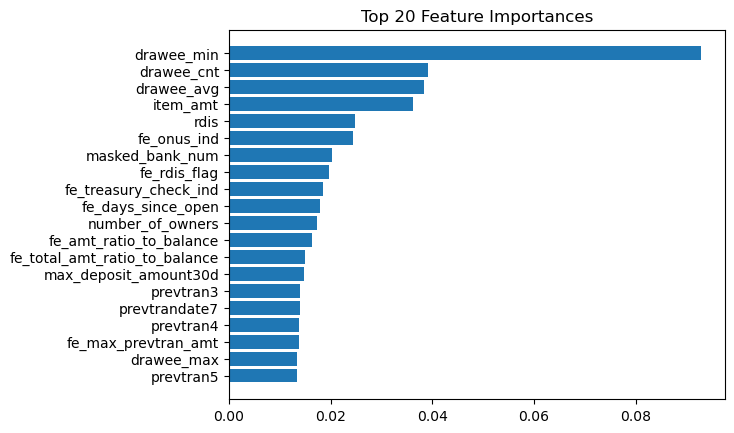

In [ ]:
import matplotlib.pyplot as plt
importances = results['feature_importances']
top_idx = np.argsort(importances)[::-1][:20]
plt.barh(range(20), importances[top_idx])
plt.yticks(range(20), X.columns[top_idx])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.show()